Загрузите набор данных о еде с метками классов из этого задания (источник оригинального набора: https://www.ars.usda.gov/northeast-area/beltsville-md-bhnrc/beltsville-human-nutrition-research-center/methods-and-application-of-food-composition-laboratory/mafcl-site-pages/sr11-sr28/, SR28ABXL.Zip (2.9 MB)-Excel file format).

Изучите полученный набор данных: все ли столбцы информативны, есть ли зависимости и т. д.

Преобразуйте набор данных, подготовив его к применению классификации методом k-ближайших соседей:
- выполните минимальные необходимые манипуляции (обработайте категориальные признаки и пропуски), а также
- отделите столбец с меткой CLASS и
- разбейте данные на тренировочный и тестовый наборы.

Обучите классификатор KNeighborsClassifier на тренировочном наборе.

Используйте обученную модель на тестовых данных, оцените полученные результаты.

Используйте визуализацию и несколько метрик.

Нормализуйте данные двумя способами (например, примените StandardScaler и MinMaxScaler).

Обучите ещё две модели на нормализованных данных. Оцените и сравните полученные результаты между собой и с результатами без нормализации.

Подберите значения гиперпараметров (количество соседей и метрику расстояния) с помощью GridSearchCV.

Сделайте выводы об использовании (плюсах и минусах) метода k-ближайших соседей для классификации в целом и применительно к рассмотренному набору данных.

Проведите предварительный отбор признаков и оцените результаты предсказаний, если:
- оставить только по одному из сильно коррелирующих признаков,
- объединить группу связанных по смыслу признаков в один (например, для витамина A),
- повторно выбирать случайным образом поднабор из нескольких признаков и запоминать лучшие результаты (например, выбирать по 5 или по 7 признаков с помощью random.sample, повторять выбор 100 раз),
- использовать методы уменьшения размерности (например, PCA),
- свой вариант отбора и подготовки признаков.


# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, ConfusionMatrixDisplay

# Датасет

In [ ]:
data = pd.read_excel('ABBREV_with_CLASS.xlsx')
data.head()

,Unnamed: 0,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),...,FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct,CLASS
0,0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,...,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0,10
1,1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,...,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0,10
2,2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,...,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0,0
3,3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,...,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0,10
4,4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,...,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0,10


NDB_No: 5-значный номер Nutrient Databank, который однозначно идентифицирует пищевой продукт.

Shrt_Desc: Сокращенное описание продукта питания длиной 60 символов.

Water_(g): Вода (г).

Energ_Kcal: Энергетическая ценность пищи (ккал).

Protein_(g): Белок (г).

Lipid_Tot_(g): Общие липиды (жиры) (г).

Ash_(g): Зола (г).

Carbohydrt_(g): Углеводы, по разнице (г).

Fiber_TD_(g): Общее количество пищевых волокон (г).

Sugar_Tot_(g): Общее количество сахаров (г).

Calcium_(mg): Кальций (мг).

Iron_(mg): Железо (мг).

Magnesium_(mg): Магний (мг).

Phosphorus_(mg): Фосфор (мг).

Potassium_(mg): Калий (мг).

Sodium_(mg): Натрий (мг).

Zinc_(mg): Цинк (мг).

Copper_(mg): Медь (мг).

Manganese_(mg): Марганец (мг).

Selenium_(μg): Селен (мкг).

Vit_C_(mg): Витамин C (мг).

Thiamin_(mg): Тиамин (мг).

Riboflavin_(mg): Рибофлавин (мг).

Niacin_(mg): Ниацин (мг).

Panto_acid_(mg): Пантотеновая кислота (мг).

Vit_B6_(mg): Витамин B6 (мг).

Folate_Tot_(μg): Фолат, всего (мкг).

Folic_acid_(μg): Фолиевая кислота (мкг).

Food_Folate_(μg): Пищевой фолат (мкг).

Folate_DFE_(μg): Фолат (мкг диетических фолатных эквивалентов).

Choline_Tot_(mg): Холин, всего (мг).

Vit_B12_(μg): Витамин B12 (мкг).

Vit_A_IU: Витамин A (IU).

Vit_A_RAE: Витамин A (мкг эквивалентов активности ретинола).

Retinol_(μg): Ретинол (мкг).

Alpha_Carot_(μg): Альфа-каротин (мкг).

Beta_Carot_(μg): Бета-каротин (мкг).

Beta_Crypt_(μg): Бета-криптоксантин (мкг).

Lycopene_(μg): Ликопин (мкг).

Lut+Zea_(μg): Лютеин+зеазантин (мкг).

Vit_E_(mg): Витамин Е (альфа-токоферол) (мг).

Vit_D_μg: Витамин D (мкг).

Vit_D_IU: Витамин D (IU).

Vit_K_(μg): Витамин К (филлохинон) (мкг).

FA_Sat_(g): Насыщенные жирные кислоты (г).

FA_Mono_(g): Мононенасыщенные жирные кислоты (г).

FA_Poly_(g): Полиненасыщенные жирные кислоты (г).

Cholestrl_(mg): Холестерин (мг).

GmWt_1: Указывает на первый стандартный вес порции продукта в граммах. Это значение связано с GmWt_Desc1.

GmWt_Desc1: Описывает, что означает вес из GmWt_1.

GmWt_2: Указывает на второй стандартный вес порции продукта в граммах. Это значение связано с GmWt_Desc2.

GmWt_Desc2: Описывает, что означает вес из GmWt_2.

Refuse_Pct: Процент отходов.

CLASS: классификация, которую мы должны понять.

Есть столбец `Unnamed: 0`, который копирует индексы, его можно удалить

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
data.describe()

,NDB_No,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),...,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct,CLASS
count,8790.000000,8789.000000,8790.000000,8790.000000,8790.000000,8465.000000,8790.000000,8196.000000,6958.000000,8442.000000,...,5579.000000,5227.000000,8441.000000,8124.000000,8125.000000,8380.000000,8490.000000,4825.000000,8740.000000,8790.000000
mean,15663.495222,54.112218,226.317634,11.342849,10.553725,1.783468,22.127710,2.187445,8.543066,76.738214,...,22.990142,15.631586,3.576334,4.081006,2.288767,40.613246,96.395130,250.747668,4.964416,5.715586
std,9251.413586,30.772854,169.877539,10.530474,15.814842,3.004609,27.270822,4.383138,14.923626,203.527453,...,154.614465,79.949125,6.518840,7.010760,5.215654,119.869371,84.337063,382.226774,12.088471,5.076376
min,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.400000,0.000000,0.000000
25%,9086.250000,29.700000,91.000000,2.380000,0.950000,0.840000,0.050000,0.000000,0.000000,10.000000,...,0.000000,0.200000,0.220000,0.235750,0.220000,0.000000,29.000000,42.000000,0.000000,0.000000
50%,14427.500000,63.080000,191.000000,8.000000,5.140000,1.200000,9.340000,0.700000,1.840000,21.000000,...,0.000000,1.600000,1.592000,1.938500,0.696000,4.000000,85.000000,164.000000,0.000000,10.000000
75%,20142.750000,77.960000,337.000000,19.880000,13.720000,2.090000,34.910000,2.600000,9.287500,69.000000,...,6.000000,5.200000,4.345000,5.115000,2.081000,67.000000,130.000000,305.000000,0.000000,10.000000
max,93600.000000,100.000000,902.000000,88.320000,100.000000,99.800000,100.000000,79.000000,99.800000,7364.000000,...,10000.000000,1714.500000,95.600000,83.689000,74.623000,3100.000000,1184.000000,5717.000000,81.000000,11.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 54 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NDB_No             8790 non-null   int64  
 1   Shrt_Desc          8790 non-null   object 
 2   Water_(g)          8789 non-null   float64
 3   Energ_Kcal         8790 non-null   int64  
 4   Protein_(g)        8790 non-null   float64
 5   Lipid_Tot_(g)      8790 non-null   float64
 6   Ash_(g)            8465 non-null   float64
 7   Carbohydrt_(g)     8790 non-null   float64
 8   Fiber_TD_(g)       8196 non-null   float64
 9   Sugar_Tot_(g)      6958 non-null   float64
 10  Calcium_(mg)       8442 non-null   float64
 11  Iron_(mg)          8646 non-null   float64
 12  Magnesium_(mg)     8051 non-null   float64
 13  Phosphorus_(mg)    8211 non-null   float64
 14  Potassium_(mg)     8364 non-null   float64
 15  Sodium_(mg)        8707 non-null   float64
 16  Zinc_(mg)          8084 

## Рассмотрим подробнее категориальные признаки

In [ ]:
data.describe(include='O')

,Shrt_Desc,GmWt_Desc1,GmWt_Desc2
count,8790,8491,4825
unique,8787,911,921
top,"OIL,INDUSTRIAL,PALM KERNEL (HYDROGENATED),CONF...",3 oz,1 cup
freq,2,1409,298


In [ ]:
data.Shrt_Desc.head(10)

,Shrt_Desc
0,"BUTTER,WITH SALT"
1,"BUTTER,WHIPPED,W/ SALT"
2,"BUTTER OIL,ANHYDROUS"
3,"CHEESE,BLUE"
4,"CHEESE,BRICK"
5,"CHEESE,BRIE"
6,"CHEESE,CAMEMBERT"
7,"CHEESE,CARAWAY"
8,"CHEESE,CHEDDAR"
9,"CHEESE,CHESHIRE"


In [ ]:
data.GmWt_Desc1.head(10)

,GmWt_Desc1
0,"1 pat, (1"" sq, 1/3"" high)"
1,"1 pat, (1"" sq, 1/3"" high)"
2,1 tbsp
3,1 oz
4,"1 cup, diced"
5,1 oz
6,1 oz
7,1 oz
8,"1 cup, diced"
9,1 oz


In [ ]:
data.GmWt_Desc2.head(10)

,GmWt_Desc2
0,1 tbsp
1,1 tbsp
2,1 cup
3,1 cubic inch
4,"1 cup, shredded"
5,"1 cup, sliced"
6,1 cup
7,NaN
8,"1 cup, melted"
9,NaN


Категориальные признаки не дают никакой новой информации. В данном датасете они просто поясняют другие столбцы, и написаны для людей. Их можно удалить.

In [ ]:
data.drop(columns=["Shrt_Desc", "GmWt_Desc1", "GmWt_Desc2"], inplace=True)

In [ ]:
data

,NDB_No,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),...,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct,CLASS
0,1001,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,14.2,0.0,10
1,1002,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,9.4,0.0,10
2,1003,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,205.0,0.0,0
3,1004,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,17.0,0.0,10
4,1005,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,113.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,83110,43.00,305,18.50,25.10,13.40,0.00,0.0,0.00,66.0,...,1006.0,7.8,7.148,8.320,6.210,95.0,80.00,17.0,0.0,0
8786,90240,70.25,111,20.54,0.84,2.97,5.41,0.0,0.00,10.0,...,2.0,0.0,0.218,0.082,0.222,41.0,85.00,NaN,0.0,0
8787,90480,26.00,269,0.00,0.00,0.86,73.14,0.0,73.20,13.0,...,0.0,0.0,0.000,0.000,0.000,0.0,21.00,NaN,0.0,10
8788,90560,79.20,90,16.10,1.40,1.30,2.00,0.0,0.00,10.0,...,0.0,0.1,0.361,0.259,0.252,50.0,85.00,NaN,0.0,0


## Рассмотрим подробнее числовые признаки

In [ ]:
len(data.NDB_No.unique())

8790

NDB_No - 5-значный номер Nutrient Databank, который однозначно идентифицирует пищевой продукт. Не несет никакой новой информации, можно удалить

In [ ]:
data.drop(columns=['NDB_No'], inplace=True)

In [ ]:
data

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct,CLASS
0,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,14.2,0.0,10
1,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,9.4,0.0,10
2,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,205.0,0.0,0
3,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,17.0,0.0,10
4,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,113.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,43.00,305,18.50,25.10,13.40,0.00,0.0,0.00,66.0,1.40,...,1006.0,7.8,7.148,8.320,6.210,95.0,80.00,17.0,0.0,0
8786,70.25,111,20.54,0.84,2.97,5.41,0.0,0.00,10.0,0.58,...,2.0,0.0,0.218,0.082,0.222,41.0,85.00,NaN,0.0,0
8787,26.00,269,0.00,0.00,0.86,73.14,0.0,73.20,13.0,3.60,...,0.0,0.0,0.000,0.000,0.000,0.0,21.00,NaN,0.0,10
8788,79.20,90,16.10,1.40,1.30,2.00,0.0,0.00,10.0,3.50,...,0.0,0.1,0.361,0.259,0.252,50.0,85.00,NaN,0.0,0


### Просмотр пропусков в колонках

In [ ]:
cols = dict()
for col in data.columns:
    cols[col] = round(float(data[col].isna().sum() / len(data[col]) * 100), 2)

cols

{'Water_(g)': 0.01,
 'Energ_Kcal': 0.0,
 'Protein_(g)': 0.0,
 'Lipid_Tot_(g)': 0.0,
 'Ash_(g)': 3.7,
 'Carbohydrt_(g)': 0.0,
 'Fiber_TD_(g)': 6.76,
 'Sugar_Tot_(g)': 20.84,
 'Calcium_(mg)': 3.96,
 'Iron_(mg)': 1.64,
 'Magnesium_(mg)': 8.41,
 'Phosphorus_(mg)': 6.59,
 'Potassium_(mg)': 4.85,
 'Sodium_(mg)': 0.94,
 'Zinc_(mg)': 8.03,
 'Copper_mg)': 14.3,
 'Manganese_(mg)': 24.57,
 'Selenium_(µg)': 19.34,
 'Vit_C_(mg)': 9.31,
 'Thiamin_(mg)': 7.21,
 'Riboflavin_(mg)': 7.01,
 'Niacin_(mg)': 7.25,
 'Panto_Acid_mg)': 25.51,
 'Vit_B6_(mg)': 10.3,
 'Folate_Tot_(µg)': 14.35,
 'Folic_Acid_(µg)': 23.2,
 'Food_Folate_(µg)': 20.11,
 'Folate_DFE_(µg)': 23.4,
 'Choline_Tot_ (mg)': 45.69,
 'Vit_B12_(µg)': 13.57,
 'Vit_A_IU': 8.09,
 'Vit_A_RAE': 17.46,
 'Retinol_(µg)': 20.55,
 'Alpha_Carot_(µg)': 37.06,
 'Beta_Carot_(µg)': 35.97,
 'Beta_Crypt_(µg)': 37.2,
 'Lycopene_(µg)': 37.45,
 'Lut+Zea_ (µg)': 37.71,
 'Vit_E_(mg)': 32.87,
 'Vit_D_µg': 37.11,
 'Vit_D_IU': 36.53,
 'Vit_K_(µg)': 40.53,
 'FA_Sat_(g)': 

In [ ]:
cols = sorted(cols.items(), key=lambda x: -x[1])

In [ ]:
cols

[('Choline_Tot_ (mg)', 45.69),
 ('GmWt_2', 45.11),
 ('Vit_K_(µg)', 40.53),
 ('Lut+Zea_ (µg)', 37.71),
 ('Lycopene_(µg)', 37.45),
 ('Beta_Crypt_(µg)', 37.2),
 ('Vit_D_µg', 37.11),
 ('Alpha_Carot_(µg)', 37.06),
 ('Vit_D_IU', 36.53),
 ('Beta_Carot_(µg)', 35.97),
 ('Vit_E_(mg)', 32.87),
 ('Panto_Acid_mg)', 25.51),
 ('Manganese_(mg)', 24.57),
 ('Folate_DFE_(µg)', 23.4),
 ('Folic_Acid_(µg)', 23.2),
 ('Sugar_Tot_(g)', 20.84),
 ('Retinol_(µg)', 20.55),
 ('Food_Folate_(µg)', 20.11),
 ('Selenium_(µg)', 19.34),
 ('Vit_A_RAE', 17.46),
 ('Folate_Tot_(µg)', 14.35),
 ('Copper_mg)', 14.3),
 ('Vit_B12_(µg)', 13.57),
 ('Vit_B6_(mg)', 10.3),
 ('Vit_C_(mg)', 9.31),
 ('Magnesium_(mg)', 8.41),
 ('Vit_A_IU', 8.09),
 ('Zinc_(mg)', 8.03),
 ('FA_Mono_(g)', 7.58),
 ('FA_Poly_(g)', 7.57),
 ('Niacin_(mg)', 7.25),
 ('Thiamin_(mg)', 7.21),
 ('Riboflavin_(mg)', 7.01),
 ('Fiber_TD_(g)', 6.76),
 ('Phosphorus_(mg)', 6.59),
 ('Potassium_(mg)', 4.85),
 ('Cholestrl_(mg)', 4.66),
 ('FA_Sat_(g)', 3.97),
 ('Calcium_(mg)', 3.9

Заметим, что есть столбцы, в которых более 30% пропусков. Такие столбцы не имеет смысл заполнять

In [ ]:
cols_for_del = [col[0] for col in cols if col[1] >= 30]

In [ ]:
cols_for_del

['Choline_Tot_ (mg)',
 'GmWt_2',
 'Vit_K_(µg)',
 'Lut+Zea_ (µg)',
 'Lycopene_(µg)',
 'Beta_Crypt_(µg)',
 'Vit_D_µg',
 'Alpha_Carot_(µg)',
 'Vit_D_IU',
 'Beta_Carot_(µg)',
 'Vit_E_(mg)']

In [ ]:
data.drop(columns=cols_for_del, inplace=True)

### Просмотр корреляций

In [ ]:
data_del = data.copy()
data_merge = data.copy()

In [ ]:
plt.figure(figsize=(120, 100))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt='.0%')

<Axes: >

In [ ]:
corr_data = data.corr()
hight_corr_data = corr_data.abs() >= 0.70
high_correlation_pairs = []

for col in hight_corr_data.columns:
    for row in hight_corr_data.index:
        if hight_corr_data.loc[row, col] and row != col:
            pair = tuple(sorted([row, col]))
            if pair not in high_correlation_pairs:
                high_correlation_pairs.append(pair)

for pair in high_correlation_pairs:
    correlation_value = corr_data.loc[pair[0], pair[1]]
    print(f"Корреляция между {pair[0]} и {pair[1]}: {correlation_value:.2f}")

Корреляция между Energ_Kcal и Water_(g): -0.90
Корреляция между Carbohydrt_(g) и Water_(g): -0.77
Корреляция между Energ_Kcal и Lipid_Tot_(g): 0.81
Корреляция между FA_Sat_(g) и Lipid_Tot_(g): 0.77
Корреляция между FA_Mono_(g) и Lipid_Tot_(g): 0.89
Корреляция между FA_Poly_(g) и Lipid_Tot_(g): 0.71
Корреляция между Ash_(g) и Sodium_(mg): 0.83
Корреляция между Niacin_(mg) и Riboflavin_(mg): 0.74
Корреляция между Niacin_(mg) и Vit_B6_(mg): 0.71
Корреляция между Folate_Tot_(µg) и Folic_Acid_(µg): 0.88
Корреляция между Folate_DFE_(µg) и Folate_Tot_(µg): 0.98
Корреляция между Folate_DFE_(µg) и Folic_Acid_(µg): 0.95
Корреляция между Vit_A_IU и Vit_A_RAE: 0.84
Корреляция между Retinol_(µg) и Vit_A_IU: 0.76
Корреляция между Retinol_(µg) и Vit_A_RAE: 0.99


Можно заметить, что есть 9 пар, у которых корреляция выше 70%. Рассмотрим их подробнее.

#### Retinol_(µg) и Vit_A_RAE - 99%

<Axes: xlabel='Retinol_(µg)', ylabel='Vit_A_RAE'>

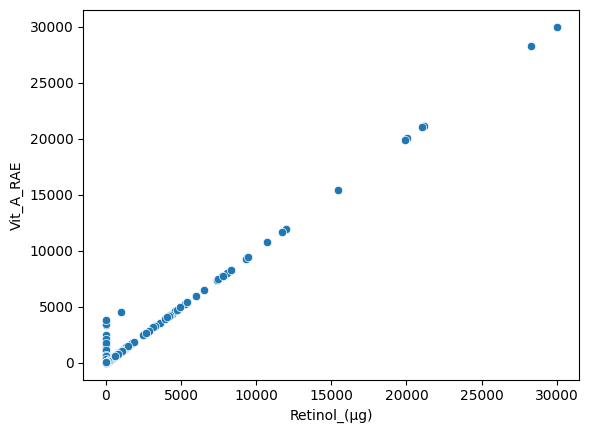

In [ ]:
sns.scatterplot(data, x='Retinol_(µg)', y='Vit_A_RAE')

Корреляция почти линейная, что логично, так как ретинол - это и есть витамин А. Можно удалить один из столбцов

In [ ]:
data["Retinol_(µg)"].isna().sum()

np.int64(1806)

In [ ]:
data["Vit_A_RAE"].isna().sum()

np.int64(1535)

Пропусков больше в ретиноле, поэтому его и отправим на удаление

In [ ]:
data_del.drop(columns=["Retinol_(µg)"], inplace=True)

In [ ]:
data_merge["A_Ret"] = data_merge[['Retinol_(µg)', 'Vit_A_RAE']].mean(axis=1, skipna=True)
data_merge.drop(columns=['Retinol_(µg)'], inplace=True)

#### Folate_DFE_(µg) и Folate_Tot_(µg) - 98%, Folate_Tot_(µg) и Folic_Acid_(µg) - 88%, Folate_DFE_(µg) и Folate_Tot_(µg) - 98%

Заметим, что есть три признака, которые сильно коррелируют между собой.

Folate_DFE (Dietary Folate Equivalent), Folate_Tot (Total Folate) и Folic_Acid — это три показателя, связанные с содержанием фолата (витамина B9) в пище и добавках.

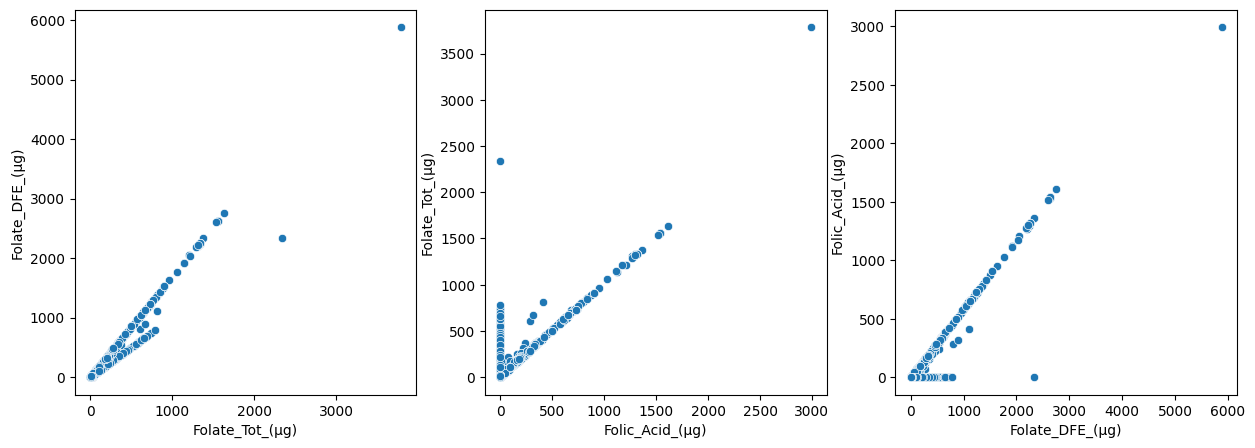

In [ ]:
plt.figure(figsize=(15, 5))
cols_fol = ["Folate_Tot_(µg)", "Folic_Acid_(µg)", "Folate_DFE_(µg)"]
for i, col in enumerate(cols_fol, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data, x=col, y=cols_fol[(i + 1) % 3])


Все три признака - Folate_DFE, Folate_Tot и Folic_Acid - тесно связаны между собой и имеют высокую положительную корреляцию. Это логично, учитывая, что они все отражают разные аспекты содержания фолата (витамина B9). Можно оставить только один из них, у которого меньше всего пропусков.

In [ ]:
for i in cols_fol:
    print(f"{i}: {data[i].isna().sum()}")

Folate_Tot_(µg): 1261
Folic_Acid_(µg): 2039
Folate_DFE_(µg): 2057


Меньше всего в Folate_Tot_(µg), его и оставим

In [ ]:
data_del.drop(columns=['Folic_Acid_(µg)', 'Folate_DFE_(µg)'], inplace=True)
data_merge["Tot_Acid_DFE"] = data_merge[['Folic_Acid_(µg)', 'Folate_DFE_(µg)']].mean(axis=1, skipna=True)
data_merge.drop(columns=['Folic_Acid_(µg)', 'Folate_DFE_(µg)'], inplace=True)

#### Energ_Kcal и Water_(g) - -90%

<Axes: xlabel='Water_(g)', ylabel='Energ_Kcal'>

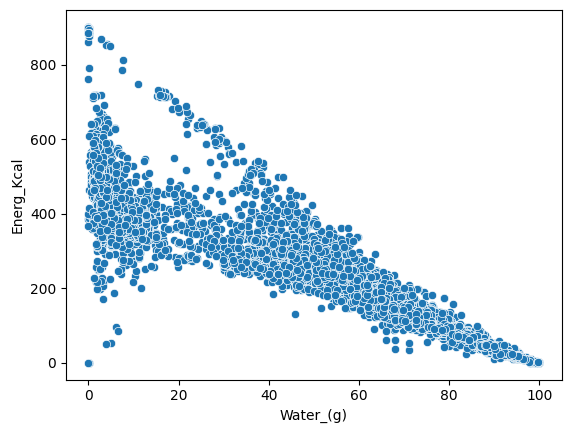

In [ ]:
sns.scatterplot(data, x='Water_(g)', y='Energ_Kcal')

Высокая корреляция, можно удалить что-нибудь.

Также заметим, что вода сильно коррелирует с Carbohydrt_(g). Посмотрим на корреляцию между Energ_Kcal и Carbohydrt_(g)

In [ ]:
corr_data.loc["Energ_Kcal", "Carbohydrt_(g)"]

np.float64(0.493027848351725)

Корреляция умеренная, поэтому лучше удалить воду и оставить Energ_Kcal и Carbohydrt_(g)

In [ ]:
data_del.drop(columns=["Water_(g)"], inplace=True)
data_merge["Water_En_Car"] = data_merge[["Energ_Kcal", "Carbohydrt_(g)", "Water_(g)"]].mean(axis=1, skipna=True)
data_merge.drop(columns=["Energ_Kcal", "Carbohydrt_(g)", "Water_(g)"], inplace=True)

#### FA_Mono_(g) и Lipid_Tot_(g) - 89%

FA_Mono (g): Это сокращение от "Fatty Acids, Monounsaturated" и обозначает содержание мононенасыщенных жирных кислот в продукте, измеренное в граммах. Мононенасыщенные жирные кислоты – это тип жиров, которые обычно считаются полезными для здоровья.

Lipid_Tot (g): Это сокращение от "Total Lipid" и обозначает общее содержание жиров (липидов) в продукте, измеренное в граммах. Этот показатель включает в себя все типы жиров: насыщенные, мононенасыщенные и полиненасыщенные.

То есть Lipid_Tot содержит в себе FA_Mono

<Axes: xlabel='FA_Mono_(g)', ylabel='Lipid_Tot_(g)'>

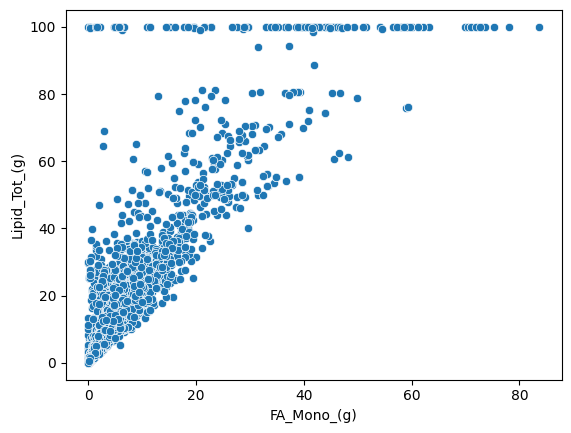

In [ ]:
sns.scatterplot(data, x='FA_Mono_(g)', y='Lipid_Tot_(g)')

Пара достаточно коррелирует, оставим только Lipid_Tot, так как он несет в себе больше знаний ( кроме FA_Mono он содержит в себе еще другие жиры )

In [ ]:
for i in ["Lipid_Tot_(g)", "FA_Mono_(g)"]:
    print(f"{i}: {data[i].isna().sum()}")

Lipid_Tot_(g): 0
FA_Mono_(g): 666


In [ ]:
data_del.drop(columns=["FA_Mono_(g)"], inplace=True)
data_merge["Water_En_Car"] = data_merge[["Lipid_Tot_(g)", "FA_Mono_(g)"]].mean(axis=1, skipna=True)
data_merge.drop(columns=["Lipid_Tot_(g)", "FA_Mono_(g)"], inplace=True)

#### Vit_A_IU и Vit_A_RAE - 84%

Vit_A_IU: Это обозначает содержание витамина A в продукте, измеренное в Международных Единицах (International Units). IU – это старая единица измерения, которая раньше широко использовалась для витаминов и лекарств.

Vit_A_RAE: Это обозначает содержание витамина A в продукте, измеренное в Микрограммах Эквивалентов Ретинола (Retinol Activity Equivalents). RAE – это более современная и точная единица измерения витамина А, которая учитывает различную биологическую активность разных форм витамина А.

По факту одно и тоже, оставим тот столбец, в котором пропусков будет меньше

In [ ]:
data.Vit_A_IU.isna().sum()

np.int64(711)

In [ ]:
data.Vit_A_RAE.isna().sum()

np.int64(1535)

Тогда выгоднее оставить Vit_A_IU, несмотря на то, что эта единица устарела.

In [ ]:
data_del.drop(columns=["Vit_A_RAE"], inplace=True)
data_merge["Vit_A"] = data_merge[["Vit_A_RAE", "Vit_A_IU"]].mean(axis=1, skipna=True)
data_merge.drop(columns=["Vit_A_RAE", "Vit_A_IU"], inplace=True)

#### Ash_(g) и Sodium_(mg) - 83%

Ash_(g) – показатель общего содержания минеральных веществ в продукте, который используется для оценки качества и питательной ценности.

Sodium_(mg) – конкретный минерал, который играет важную роль в физиологических процессах, но требует контроля из-за потенциального вреда при чрезмерном потреблении.

<Axes: xlabel='Ash_(g)', ylabel='Sodium_(mg)'>

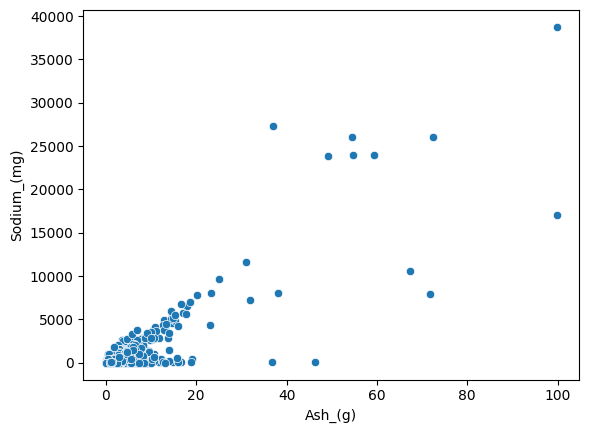

In [ ]:
sns.scatterplot(data, x='Ash_(g)', y='Sodium_(mg)')

Несмотря на высокий процент корреляции, корреляция выглядит слабой и нелинейной. Оставим оба признака, тем более они имеют разные смыслы.

#### Energ_Kcal и Lipid_Tot_(g): 0.81

Energ_Kcal (энергетическая ценность в килокалориях): Это количество энергии, которое организм получает из пищи при её усвоении.

Lipid_Tot_(g) (общее содержание жиров в граммах): Это показатель, который отражает общее количество жиров в продукте.

<Axes: xlabel='Energ_Kcal', ylabel='Lipid_Tot_(g)'>

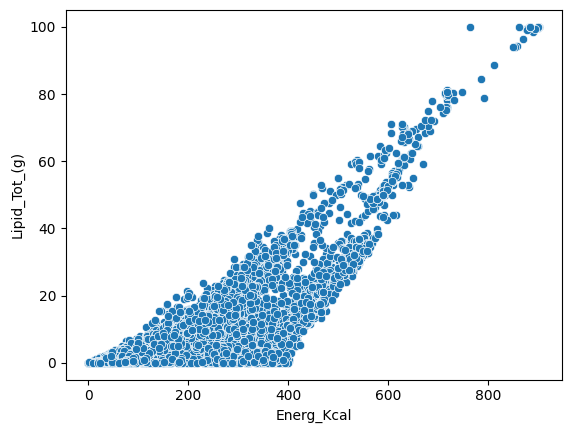

In [ ]:
sns.scatterplot(data, x='Energ_Kcal', y='Lipid_Tot_(g)')

Корреляция есть, но не слишком сильная, чтобы что-то удалять. Лучше оставить оба признака.

#### FA_Sat_(g) и Lipid_Tot_(g) - 77%

FA_Sat_(g) – конкретный тип жира, который может иметь негативное влияние на здоровье при чрезмерном потреблении.

Lipid_Tot_(g) – общий показатель, который включает все виды жиров.

<Axes: xlabel='FA_Sat_(g)', ylabel='Lipid_Tot_(g)'>

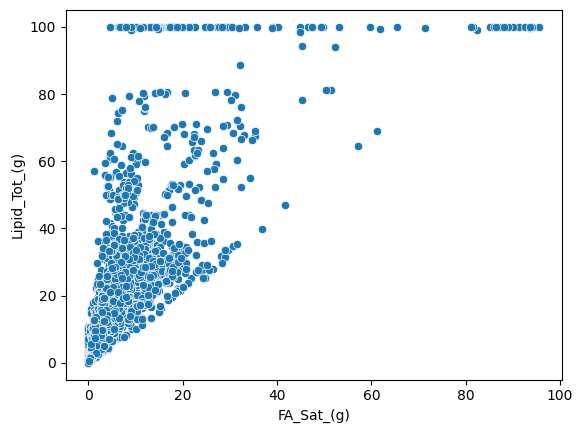

In [ ]:
sns.scatterplot(data, x='FA_Sat_(g)', y='Lipid_Tot_(g)')

Корреляция есть, но она сложная, оставляем

#### Niacin_(mg) и Riboflavin_(mg) - 74%

Niacin_(mg) (никотиновая кислота) — водорастворимый витамин, участвующий в метаболизме жиров, углеводов и белков.

Riboflavin_(mg) — витамин, критически важный для синтеза гемоглобина, усвоения железа и работы надпочечников.

Коррелировать не будут

<Axes: xlabel='Niacin_(mg)', ylabel='Riboflavin_(mg)'>

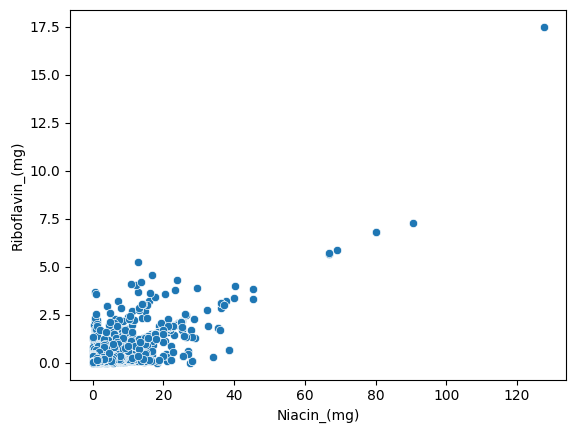

In [ ]:
sns.scatterplot(data, x='Niacin_(mg)', y='Riboflavin_(mg)')

Очень слабая корреляция, оставляем оба признака

#### FA_Poly_(g) и Lipid_Tot_(g) - 71%

FA_Poly_(g) — конкретный тип жира с доказанными полезными свойствами.

Lipid_Tot_(g) — общий показатель, который включает как полезные, так и потенциально вредные жиры.

<Axes: xlabel='FA_Poly_(g)', ylabel='Lipid_Tot_(g)'>

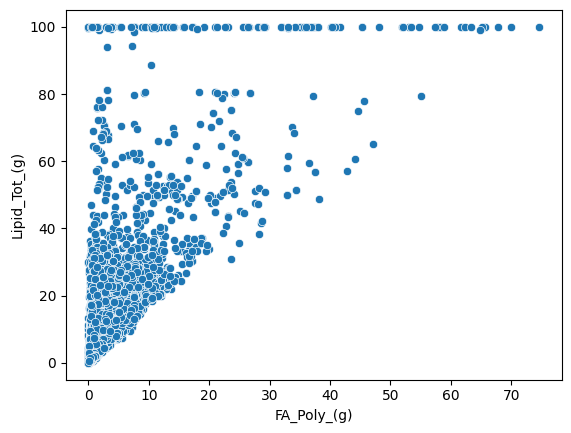

In [ ]:
sns.scatterplot(data, x='FA_Poly_(g)', y='Lipid_Tot_(g)')

Наблюдается умеренная положительная корреляция, однако эта зависимость сложная и нелинейная. Оставляем оба признака

#### Niacin_(mg) и Vit_B6_(mg) - 71%

Niacin_(mg) (никотиновая кислота) — водорастворимый витамин, участвующий в метаболизме жиров, углеводов и белков.

Vit_B6  — ключевой кофактор для более чем 150 ферментативных реакций, включая метаболизм аминокислот и синтез нейромедиаторов.

По логике разные признаки

<Axes: xlabel='Niacin_(mg)', ylabel='Vit_B6_(mg)'>

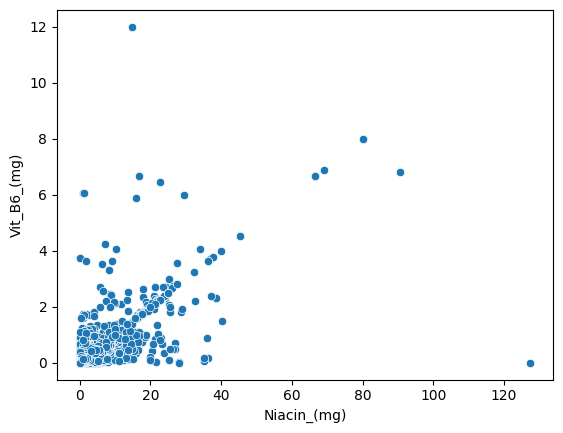

In [ ]:
sns.scatterplot(data, x='Niacin_(mg)', y='Vit_B6_(mg)')

Оставляем.

# Работа с пропусками

In [ ]:
data

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_A_IU,Vit_A_RAE,Retinol_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,Refuse_Pct,CLASS
0,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,...,2499.0,684.0,671.0,51.368,21.021,3.043,215.0,5.00,0.0,10
1,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,...,2468.0,683.0,671.0,45.390,19.874,3.331,225.0,3.80,0.0,10
2,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,...,3069.0,840.0,824.0,61.924,28.732,3.694,256.0,12.80,0.0,0
3,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,...,721.0,198.0,192.0,18.669,7.778,0.800,75.0,28.35,0.0,10
4,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,...,1080.0,292.0,286.0,18.764,8.598,0.784,94.0,132.00,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,43.00,305,18.50,25.10,13.40,0.00,0.0,0.00,66.0,1.40,...,157.0,47.0,47.0,7.148,8.320,6.210,95.0,80.00,0.0,0
8786,70.25,111,20.54,0.84,2.97,5.41,0.0,0.00,10.0,0.58,...,5.0,2.0,2.0,0.218,0.082,0.222,41.0,85.00,0.0,0
8787,26.00,269,0.00,0.00,0.86,73.14,0.0,73.20,13.0,3.60,...,0.0,0.0,0.0,0.000,0.000,0.000,0.0,21.00,0.0,10
8788,79.20,90,16.10,1.40,1.30,2.00,0.0,0.00,10.0,3.50,...,100.0,30.0,30.0,0.361,0.259,0.252,50.0,85.00,0.0,0


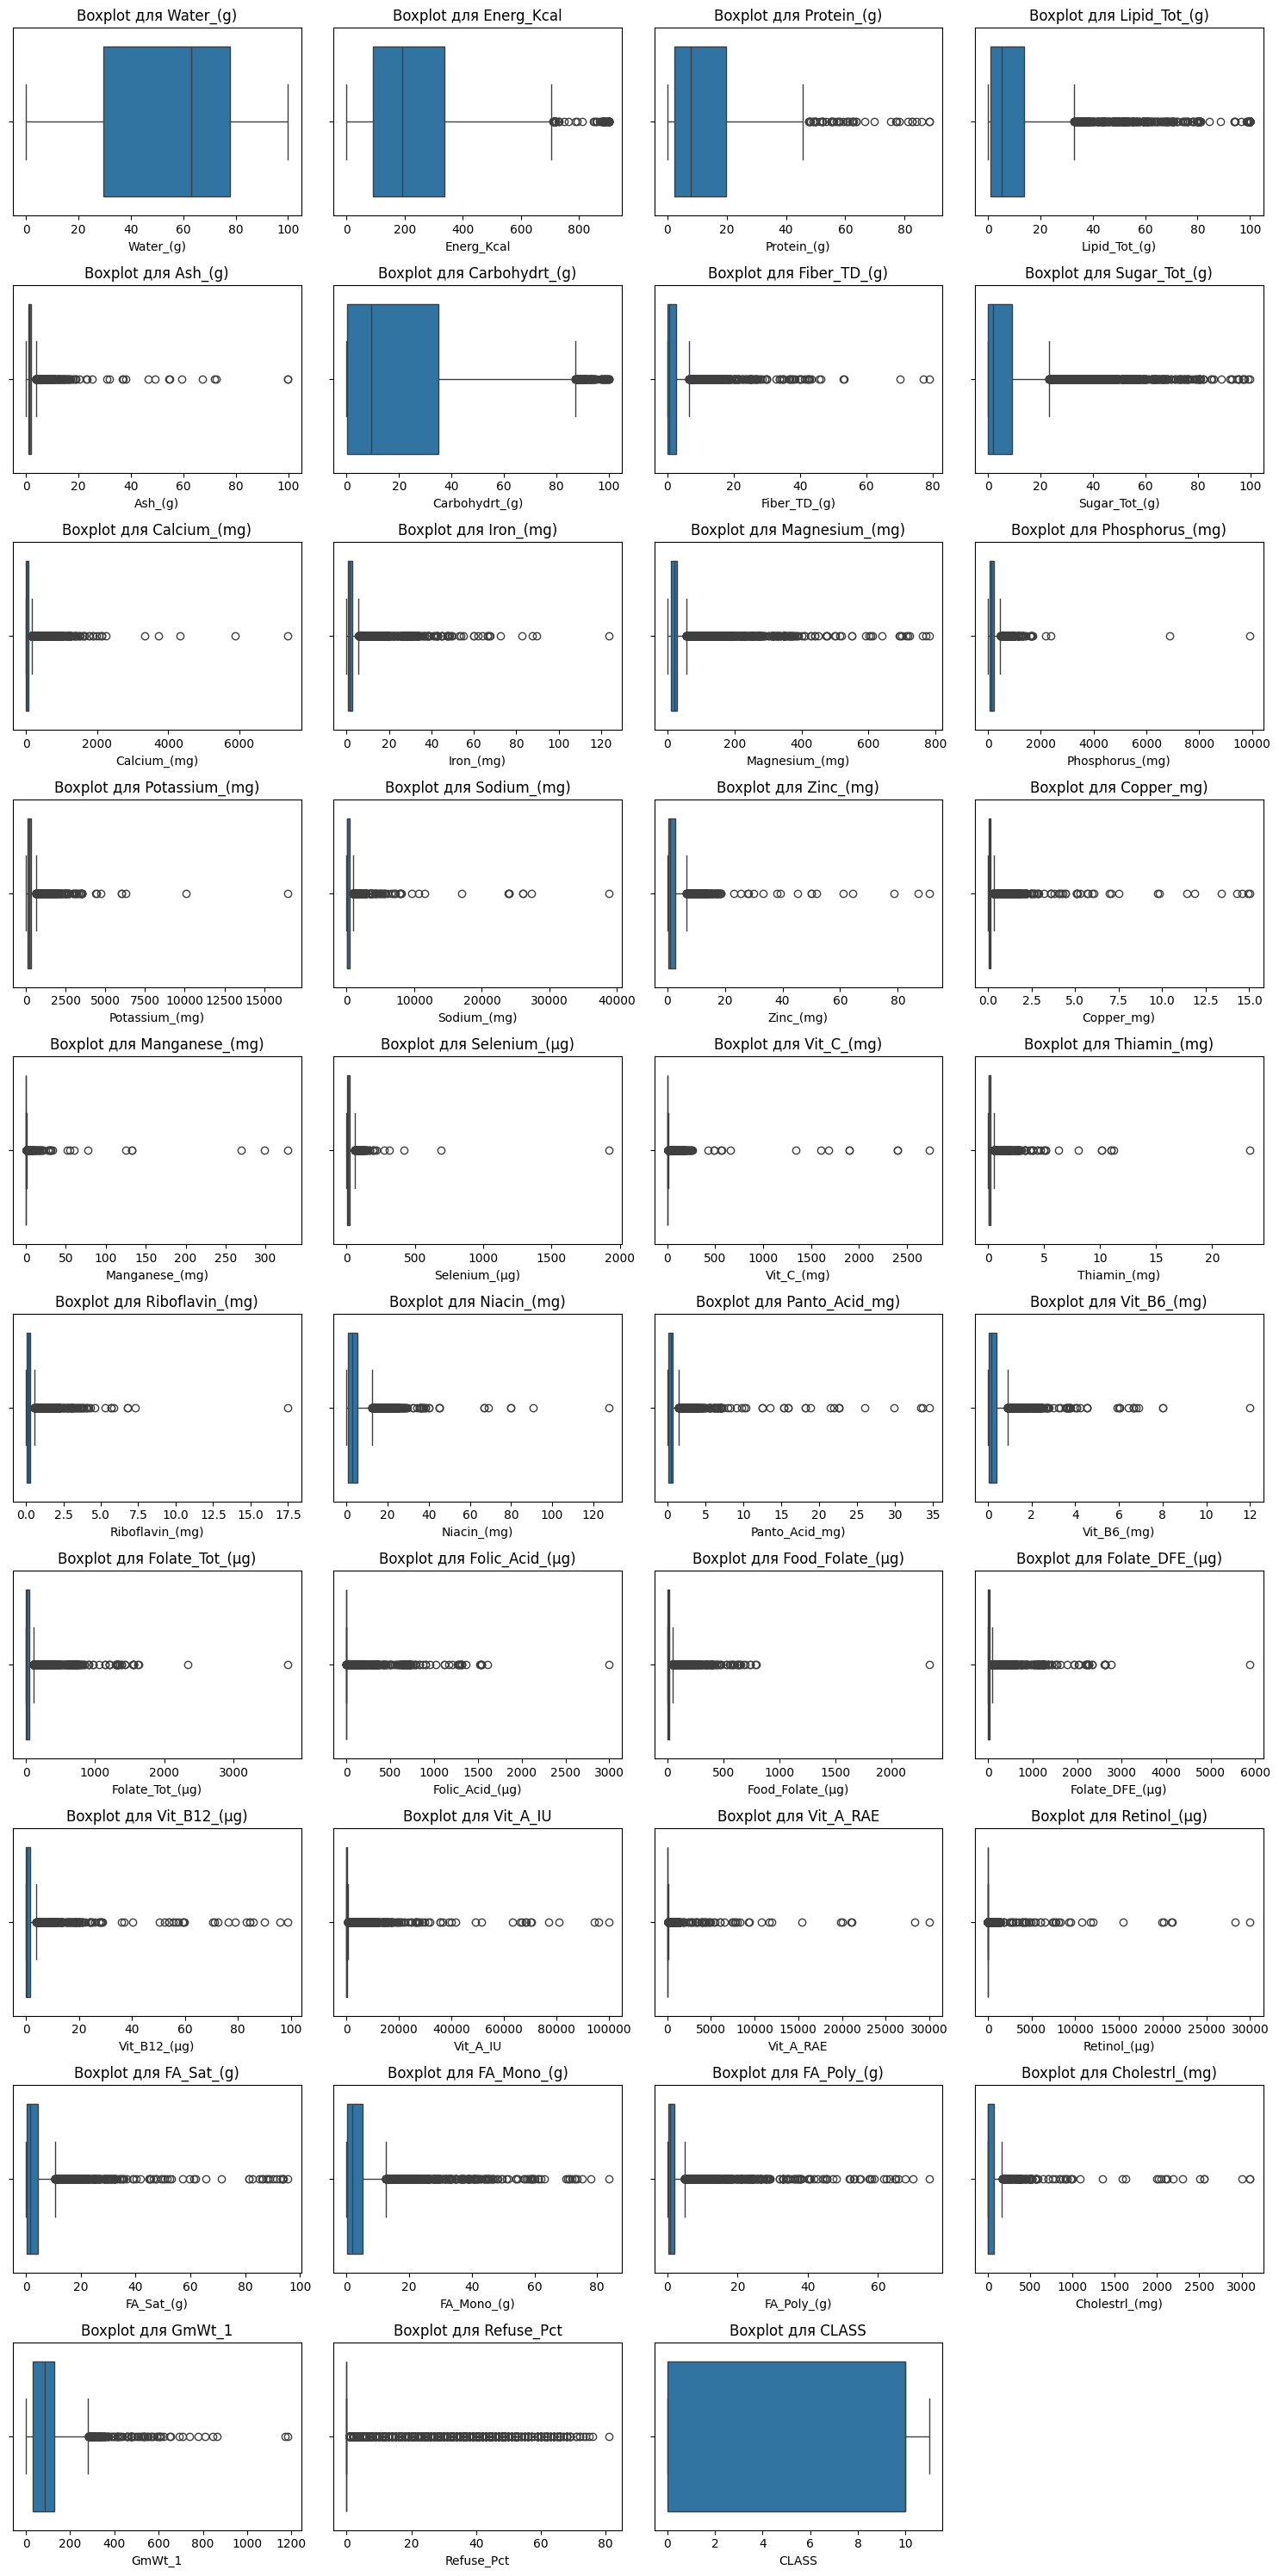

In [ ]:
plt.figure(figsize=(15, 30))
for i, column in enumerate(data.columns, 1):
    plt.subplot(10, 4, i)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot для {column}')
plt.tight_layout()
plt.show()

# Отделение столбца с меткой CLASS и разбитие данных на тренировочный и тестовый наборы

In [ ]:
data_all = pd.read_excel('ABBREV_with_CLASS.xlsx')
data_all.drop(columns=["Shrt_Desc", "GmWt_Desc1", "GmWt_Desc2"], inplace=True)

In [ ]:
standart_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
data.CLASS.isna().sum()

np.int64(0)

In [ ]:
def train_test(data):
    X = data.drop(columns='CLASS')
    y = data['CLASS']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test(data)
X_train_del, X_test_del, y_train_del, y_test_del = train_test(data_del)
X_train_merge, X_test_merge, y_train_merge, y_test_merge = train_test(data_merge)
X_train_all, X_test_all, y_train_all, y_test_all = train_test(data_all)

# Обучение

## Без нормализации

In [ ]:
pipe_lines = [
    Pipeline([
        ('imputer', SimpleImputer()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy='constant')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='distance')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=9, weights='distance')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='uniform')),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=9, weights='uniform')),
        ('knn', KNeighborsClassifier())
    ])
    ]

### Без удаления коррелирующих столбцов

In [ ]:
for pipe_line in pipe_lines:
    print(pipe_line)
    pipe_line.fit(X_train, y_train)
    y_pred = pipe_line.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Pipeline(steps=[('imputer', SimpleImputer()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7717102768297307

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7694349639742131

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7717102768297307

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7720894956389837

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7709518392112249

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=9, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7682973075464543

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7743648084945013

Pi

Лучшие решения:

KNNImputer(n_neighbors=10)
- Accuracy: 0.7744
- Наивысший результат, превосходит все простые стратегии

SimpleImputer(strategy='constant')
- Accuracy: 0.7721
- Второе место среди всех методов

Ключевые наблюдения:
- KNNImputer с 10 соседями показал лучшую точность, что может указывать на эффективность использования соседей для заполнения пропусков.

- SimpleImputer с константой также показал хорошие результаты, но уступает KNNImputer.

### Удаление коррелирующих столбцов

In [ ]:
for pipe_line in pipe_lines:
    print(pipe_line)
    pipe_line.fit(X_train_del, y_train_del)
    y_pred_del = pipe_line.predict(X_test_del)
    print(f"Accuracy: {accuracy_score(y_test_del, y_pred_del)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test_del, y_pred_del)

Pipeline(steps=[('imputer', SimpleImputer()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7629882442169131

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7679180887372014

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7732271520667425

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7736063708759955

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7667804323094426

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=9, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7629882442169131

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7694349639742131

Pi

Лучшие решения:

SimpleImputer(strategy='constant')
- Accuracy: 0.7736
- Наивысший результат среди всех методов

SimpleImputer(strategy='most_frequent')
- Accuracy: 0.7732
- Минимально уступает лидеру (разница всего ~0.04%)

Интересные наблюдения:
- KNNImputer в этом наборе данных показал худшие результаты, чем простые стратегии импутации (максимум 0.7694 vs 0.7736 у SimpleImputer).

- Использование weights='distance' в KNNImputer ухудшило точность на 0.2-0.6%.

Чуть лучше, чем было

### Объединение коррелирующих столбцов в один

In [ ]:
for pipe_line in pipe_lines:
    print(pipe_line)
    pipe_line.fit(X_train_merge, y_train_merge)
    y_pred_merge = pipe_line.predict(X_test_merge)
    print(f"Accuracy: {accuracy_score(y_test_merge, y_pred_merge)}\n")
    #ConfusionMatrixDisplay.from_predictions(y_test_merge, y_pred_merge)

Pipeline(steps=[('imputer', SimpleImputer()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7444065225635191

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7432688661357604

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7447857413727721

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7474402730375427

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7182404247250663

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=9, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7178612059158134

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7243079256731134

Pi

Лучшие решения:

SimpleImputer(strategy='constant')
- Accuracy: 0.7474
- Совершенно явный лидер в этом эксперименте

SimpleImputer(strategy='most_frequent')
- Accuracy: 0.7447
- Уступает лидеру всего на ~0.27%, но стабильно в топе

Ключевые наблюдения:
- KNNImputer показал катастрофически низкие результаты (на 2-3% хуже SimpleImputer), что показывает его нецелесообразное использование для этих данных.

- Стратегия constant снова подтвердила свою эффективность, как в предыдущих экспериментах.

- Все варианты KNNImputer (даже с разными гиперпараметрами) проигрывают простым методам, что может указывать на:

    - Сильную зашумленность данных

    - Неоптимальность KNN-подхода для конкретного распределения пропусков


### Без удаления каких-либо данных

In [ ]:
for pipe_line in pipe_lines:
    print(pipe_line)
    pipe_line.fit(X_train_all, y_train_all)
    y_pred_all = pipe_line.predict(X_test_all)
    print(f"Accuracy: {accuracy_score(y_test_all, y_pred_all)}\n")
    #ConfusionMatrixDisplay.from_predictions(y_test_merge, y_pred_merge)

Pipeline(steps=[('imputer', SimpleImputer()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8464163822525598

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7937049677664012

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7959802806219188

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7967387182404247

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7857413727720894

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=9, weights='distance')),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7868790291998483

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7895335608646189

Pi

Лучшие решения:

SimpleImputer() (по умолчанию, обычно mean)
- Accuracy: 0.8464
- Наивысший результат, значительно превосходит другие методы

SimpleImputer(strategy='constant')
- Accuracy: 0.7967
- Второе место среди простых стратегий

Ключевые наблюдения:
- SimpleImputer() (mean) показал значительно лучшие результаты (0.8464), что может указывать на то, что среднее значение является наиболее подходящим для заполнения пропусков в этом наборе данных.

- KNNImputer в целом показал меньшую точность по сравнению с простыми стратегиями, особенно с SimpleImputer().

- Использование constant и most_frequent дало схожие результаты, но уступают SimpleImputer().

#### Вывод:

По итогу ьез нормализации лучшие результаты показало заполнение пропусков SimpleImputer() (mean) **0.8464**, на данных, над которыми ничего не делали.

## Нормализация

### MinMaxScaler

In [ ]:
pipe_lines_min_max = [
    Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
        Pipeline([
        ('imputer', SimpleImputer(strategy='constant')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='distance')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=9, weights='distance')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=10, weights='uniform')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', KNNImputer(n_neighbors=9, weights='uniform')),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])
]

#### Без удаления

In [ ]:
for pipe_line in pipe_lines_min_max:
    print(pipe_line)
    pipe_line.fit(X_train, y_train)
    y_pred = pipe_line.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.882062950322336

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8532423208191127

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8722032612817596

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8691695108077361

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8350398179749715

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8342813803564657

Pipel

Лучшие решения:

SimpleImputer() + MinMaxScaler()
- Accuracy: 0.8821
- Наивысший результат, значительно превосходит другие методы

SimpleImputer(strategy='most_frequent') + MinMaxScaler()
- Accuracy: 0.8722
- Второе место среди всех методов

Ключевые наблюдения:
- Добавление MinMaxScaler() существенно улучшило точность по сравнению с предыдущими экспериментами, что указывает на важность масштабирования данных для KNN-классификатора.

- SimpleImputer() (mean) показал лучшие результаты, что может указывать на эффективность использования среднего значения для заполнения пропусков в этом наборе данных.

#### С удалением

In [ ]:
for pipe_line in pipe_lines_min_max:
    print(pipe_line)
    pipe_line.fit(X_train_del, y_train_del)
    y_pred_del = pipe_line.predict(X_test_del)
    print(f"Accuracy: {accuracy_score(y_test_del, y_pred_del)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test_del, y_pred_del)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8824421691315889

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8558968524838833

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8733409177095184

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8733409177095184

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8289723170269245

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8316268486916951

Pipe

Лучшие решения:

SimpleImputer() + MinMaxScaler()
- Accuracy: 0.8824
- Наивысший результат, значительно превосходит другие методы

SimpleImputer(strategy='most_frequent') + MinMaxScaler()
- Accuracy: 0.8733
- Второе место среди всех методов, совпадает с constant

#### С объединением

In [ ]:
for pipe_line in pipe_lines_min_max:
    print(pipe_line)
    pipe_line.fit(X_train_merge, y_train_merge)
    y_pred_merge = pipe_line.predict(X_test_merge)
    print(f"Accuracy: {accuracy_score(y_test_merge, y_pred_merge)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test_del, y_pred_del)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8551384148653773

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8293515358361775

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8517254455821008

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8505877891543421

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7959802806219188

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.7944634053849071

Pipe

Лучшие решения:

SimpleImputer() + MinMaxScaler()
- Accuracy: 0.8551
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='most_frequent') + MinMaxScaler()
- Accuracy: 0.8517
- Второе место среди всех методов

#### Без удаления каких-либо данных

In [ ]:
for pipe_line in pipe_lines_min_max:
    print(pipe_line)
    pipe_line.fit(X_train_all, y_train_all)
    y_pred_all = pipe_line.predict(X_test_all)
    print(f"Accuracy: {accuracy_score(y_test_all, y_pred_all)}\n")
    #ConfusionMatrixDisplay.from_predictions(y_test_merge, y_pred_merge)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8794084186575654

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.863481228668942

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8729616989002654

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8771331058020477

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.832385286310201

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8350398179749715

Pipeli

Лучшие решения:

SimpleImputer() + MinMaxScaler()
- Accuracy: 0.8794
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='constant') + MinMaxScaler()
- Accuracy: 0.8771
- Второе место среди всех методов

SimpleImputer(strategy='most_frequent') + MinMaxScaler()
- Accuracy: 0.8729
- Третье место, близко к лидерам

##### Выводы:

По итогу с MinMax нормализацией лучший результат показал SimpleImputer() (mean) **0.8824** на данных, в которых удаляли сильно-коррелирующие столбцы.

### StandartScaler

In [ ]:
pipe_line_a = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_line_b = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_line_c = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_line_d = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_line_e = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_line_f = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

#### Без удаления

In [ ]:
for pipe_line in [pipe_line_a, pipe_line_b, pipe_line_c, pipe_line_d, pipe_line_e, pipe_line_f]:
    print(pipe_line)
    pipe_line.fit(X_train, y_train)
    y_pred = pipe_line.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8543799772468714

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8441410693970421

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8532423208191127

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8532423208191127

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8350398179749715

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.83428138035646

Лучшие решения:

SimpleImputer() + StandardScaler()
- Accuracy: 0.8544
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='most_frequent') + StandardScaler()
- Accuracy: 0.8532
- Второе место среди всех методов, совпадает с constant

Ключевые наблюдения:
- StandardScaler() показал хорошие результаты, хотя и немного уступает MinMaxScaler() в других экспериментах.

- SimpleImputer() (mean) снова подтвердил свою эффективность, что может указывать на важность использования среднего значения для заполнения пропусков в этом наборе данных.

- KNNImputer в целом показал меньшую точность по сравнению с простыми стратегиями, особенно с SimpleImputer().

#### С удалением

In [ ]:
for pipe_line in [pipe_line_a, pipe_line_b, pipe_line_c, pipe_line_d, pipe_line_e, pipe_line_f]:
    print(pipe_line)
    pipe_line.fit(X_train_del, y_train_del)
    y_pred_del = pipe_line.predict(X_test_del)
    print(f"Accuracy: {accuracy_score(y_test_del, y_pred_del)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test_del, y_pred_del)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8498293515358362

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8430034129692833

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8540007584376185

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8547591960561244

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8289723170269245

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.83162684869169

Лучшие решения:

SimpleImputer(strategy='constant') + StandardScaler()
- Accuracy: 0.8548
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='most_frequent') + StandardScaler()
- Accuracy: 0.8540
- Второе место среди всех методов

#### С объединением

In [ ]:
for pipe_line in [pipe_line_a, pipe_line_b, pipe_line_c, pipe_line_d, pipe_line_e, pipe_line_f]:
    print(pipe_line)
    pipe_line.fit(X_train_merge, y_train_merge)
    y_pred_merge = pipe_line.predict(X_test_merge)
    print(f"Accuracy: {accuracy_score(y_test_merge, y_pred_merge)}\n")
    # ConfusionMatrixDisplay.from_predictions(y_test_del, y_pred_del)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8308684110731892

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.819491846795601

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8274554417899128

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8293515358361775

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.7959802806219188

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.794463405384907

Лучшие решения:

SimpleImputer() + StandardScaler()
- Accuracy: 0.8309
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='constant') + StandardScaler()
- Accuracy: 0.8294
- Второе место среди всех методов

#### Без удаления каких-либо данных

In [ ]:
for pipe_line in [pipe_line_a, pipe_line_b, pipe_line_c, pipe_line_d, pipe_line_e, pipe_line_f]:
    print(pipe_line)
    pipe_line.fit(X_train_all, y_train_all)
    y_pred_all = pipe_line.predict(X_test_all)
    print(f"Accuracy: {accuracy_score(y_test_all, y_pred_all)}\n")
    #ConfusionMatrixDisplay.from_predictions(y_test_merge, y_pred_merge)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8775123246113007

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8536215396283656

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.869927948426242

Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                ('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.8748577929465301

Pipeline(steps=[('imputer', KNNImputer(weights='distance')),
                ('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())])
Accuracy: 0.832385286310201

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier())])
Accuracy: 0.8350398179749715

Лучшие решения:

SimpleImputer() + StandardScaler()
- Accuracy: 0.8775
- Наивысший результат, превосходит другие методы

SimpleImputer(strategy='constant') + StandardScaler()
- Accuracy: 0.8749
- Второе место среди всех методов

##### Выводы:

Лучшие результаты показал SimpleImputer() (mean) - **0.8775** на данных, над которыми ничего не делали.

StandartScaler() показывает результаты в целом хуже, чем MinMaxScaler()

## Гиперпараметры

In [ ]:
pipe_lines_grid = [
    Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])
]

In [ ]:
param_grid = {
    'knn__n_neighbors': [x for x in range(2, 15)],
    'knn__metric': ['manhattan']
}

### Без удаления

In [ ]:
best_accuracy = -np.inf
best_params = dict()
best_score = -np.inf
best_model = None
for pipe in pipe_lines_grid:
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_model = pipe

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        best_accuracy = accuracy


In [ ]:
print(f"Лучшая модель: {best_model}")
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.4f}")

print(f"Точность на тестовых данных: {best_accuracy:.4f}")

Лучшая модель: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])
Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Лучшая точность: 0.8927
Точность на тестовых данных: 0.8991


### С удалением

In [ ]:
best_accuracy = -np.inf
best_params = dict()
best_score = -np.inf
best_model = None
for pipe in pipe_lines_grid:
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_del, y_train_del)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_model = pipe

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_del)

        accuracy = accuracy_score(y_test_del, y_pred)
        best_accuracy = accuracy


In [ ]:
print(f"Лучшая модель: {best_model}")
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.4f}")

print(f"Точность на тестовых данных: {best_accuracy:.4f}")

Лучшая модель: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=6))])
Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 6}
Лучшая точность: 0.8926
Точность на тестовых данных: 0.8934


### Без удаления каких-либо данных

In [ ]:
best_accuracy = -np.inf
best_params = dict()
best_score = -np.inf
best_model = None
for pipe in pipe_lines_grid:
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_all, y_train_all)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_model = pipe

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_all)

        accuracy = accuracy_score(y_test_all, y_pred_all)
        best_accuracy = accuracy

In [ ]:
print(f"Лучшая модель: {best_model}")
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.4f}")

print(f"Точность на тестовых данных: {best_accuracy:.4f}")

Лучшая модель: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])
Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Лучшая точность: 0.9062
Точность на тестовых данных: 0.8350


### Вывод:

Лучшая модель на тренировочных данных:

- Пайплайн: SimpleImputer() для импутации пропущенных значений, MinMaxScaler() для масштабирования данных, и KNeighborsClassifier() для классификации.

- Параметры классификатора: Использование метрики Manhattan и количество соседей 3.

Лучшие параметры:

- Метрика расстояния: Manhattan

- Количество соседей: 3

Данные: без удаления любых столбцов.

Точность на обучающих данных: 0.9062
Точность на тестовых данных: 0.8350

Эта модель показала наивысшую точность на обучающих данных, но на тестовых данных точность была ниже, что может указывать на переобучение.

Лучшая модель на тестовых данных:

- Пайплайн: SimpleImputer() для импутации пропущенных значений, MinMaxScaler() для масштабирования данных, и KNeighborsClassifier() для классификации.

- Параметры классификатора: Использование метрики Manhattan и количество соседей 3.

Лучшие параметры:

- Метрика расстояния: Manhattan

- Количество соседей: 3

Данные: удаление столбуов с большим количеством пропусков.

Точность на обучающих данных: 0.8927
Точность на тестовых данных: 0.8991

Эта модель показала высокую точность как на обучающих, так и на тестовых данных, что указывает на хорошую обобщаемость модели.

## Рандомные поднаборы

Так как по прошлым результатам лучшую точность показал SimpleImputer() с MinMaxScaler(), то будем проверять его

### Неочищенные данные:

#### 5 признаков

In [ ]:
pipe5 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data_all["CLASS"]
data_x = data_all.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Sugar_Tot_(g)', 'Phosphorus_(mg)', 'Folate_Tot_(µg)', 'Zinc_(mg)',
       'Vit_D_IU', 'Energ_Kcal', 'Lycopene_(µg)'],
      dtype='object')
Лучшая оценка: 0.9105043610163064


#### 6 признаков

In [ ]:
pipe6 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data_all["CLASS"]
data_x = data_all.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(6, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Sugar_Tot_(g)', 'Vit_K_(µg)', 'Vit_A_RAE', 'Calcium_(mg)', 'Water_(g)',
       'Iron_(mg)'],
      dtype='object')
Лучшая оценка: 0.9142965491088358


#### 7 признаков

In [ ]:
pipe7 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data_all["CLASS"]
data_x = data_all.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe7.fit(X_train, y_train)
    y_pred = pipe7.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Beta_Crypt_(µg)', 'Manganese_(mg)', 'Water_(g)', 'Sodium_(mg)',
       'Lycopene_(µg)', 'Protein_(g)', 'Sugar_Tot_(g)'],
      dtype='object')
Лучшая оценка: 0.9196056124383769


### Вывод:

Лучшую точность **0.9196** показал поднабор из 7 столбцов - ['Beta_Crypt_(µg)', 'Manganese_(mg)', 'Water_(g)', 'Sodium_(mg)',
       'Lycopene_(µg)', 'Protein_(g)', 'Sugar_Tot_(g)']

### Почищенные данные:

#### 5 признаков

In [ ]:
pipe5 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data["CLASS"]
data_x = data.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Magnesium_(mg)', 'Retinol_(µg)', 'Sugar_Tot_(g)', 'Ash_(g)',
       'Calcium_(mg)', 'Fiber_TD_(g)', 'Water_(g)'],
      dtype='object')
Лучшая оценка: 0.912779673871824


#### 6 признаков

In [ ]:
pipe6 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data["CLASS"]
data_x = data.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(6, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Panto_Acid_mg)', 'Sugar_Tot_(g)', 'Calcium_(mg)', 'Vit_B12_(µg)',
       'GmWt_1', 'Water_(g)'],
      dtype='object')
Лучшая оценка: 0.9025407660219947


#### 7 признаков

In [ ]:
pipe7 = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
best_cols = None
best_score = -1
y = data["CLASS"]
data_x = data.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe7.fit(X_train, y_train)
    y_pred = pipe7.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Riboflavin_(mg)', 'Protein_(g)', 'Folate_DFE_(µg)', 'Sugar_Tot_(g)',
       'Water_(g)', 'FA_Mono_(g)', 'Potassium_(mg)'],
      dtype='object')
Лучшая оценка: 0.9124004550625711


### Вывод:

Лучшую точность **0.9128** показал поднабор из 5 столбцов - ['Magnesium_(mg)', 'Retinol_(µg)', 'Sugar_Tot_(g)', 'Ash_(g)',
       'Calcium_(mg)', 'Fiber_TD_(g)', 'Water_(g)']

Результат уступает результату на неочищенных данных.

## Методы уменьшения размерности - PCA

In [ ]:
pcapipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
pcapipe.fit(X_train, y_train)
y_pred = pcapipe.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7159651118695487

In [ ]:
pcapipe.fit(X_train_all, y_train_all)
y_pred_all = pcapipe.predict(X_test_all)

In [ ]:
accuracy_score(y_test_all, y_pred_all)

0.8794084186575654

Относительно плохие результаты

## Своё разбиение

In [ ]:
data_my = data[[
    'Water_(g)', 'Protein_(g)', 'Sugar_Tot_(g)', 'Retinol_(µg)', 'CLASS', 'Energ_Kcal'
]]

In [ ]:
pipe_my = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [ ]:
X_train_my, X_test_my, y_train_my, y_test_my = train_test(data_my)

In [ ]:
pipe_my.fit(X_train_my, y_train_my)
y_pred_my = pipe_my.predict(X_test_my)

In [ ]:
accuracy_score(y_test_my, y_pred_my)

0.9116420174440653

# Баловство

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neural_network import MLPRegressor

In [ ]:
imputer = IterativeImputer(
    estimator=MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300),
    max_iter=100
)

scaler = MinMaxScaler()
data_all_scaled = scaler.fit_transform(data_all)

imputer.fit(data_all_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=MLPRegressor(hidden_layer_sizes=(100, 50),
                                        max_iter=300),
                 max_iter=100)

In [ ]:
data_all_imp = imputer.transform(data_all_scaled)


In [ ]:
data_all_imp_df = pd.DataFrame(data_all_imp, columns=data_all.columns)

In [ ]:
data_all_imp_df.drop(columns=['Unnamed: 0', 'NDB_No'], inplace=True)

In [ ]:
data_all_imp_df.reset_index(drop=True)

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct,CLASS
0,0.1587,0.794900,0.009624,0.8111,0.021142,0.0006,0.0,0.000601,0.003259,0.000162,...,0.0000,0.004083,0.537322,0.251180,0.040778,0.069355,0.004139,0.002414,0.0,0.909091
1,0.1672,0.796009,0.005548,0.7830,0.016232,0.0287,0.0,0.000601,0.003123,0.000405,...,0.0000,0.002683,0.474791,0.237474,0.044638,0.072581,0.003125,0.001574,0.0,0.909091
2,0.0024,0.971175,0.003170,0.9948,0.000000,0.0000,0.0,0.000000,0.000543,0.000000,...,0.0000,0.005016,0.647741,0.343319,0.049502,0.082581,0.010727,0.035791,0.0,0.000000
3,0.4241,0.391353,0.242301,0.2874,0.051202,0.0234,0.0,0.005010,0.071700,0.002508,...,0.0021,0.001400,0.195282,0.092939,0.010721,0.024194,0.023862,0.002904,0.0,0.909091
4,0.4111,0.411308,0.263134,0.2968,0.031864,0.0279,0.0,0.005110,0.091526,0.003479,...,0.0022,0.001458,0.196276,0.102738,0.010506,0.030323,0.111411,0.019697,0.0,0.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,0.4300,0.338137,0.209466,0.2510,0.134269,0.0000,0.0,0.000000,0.008963,0.011327,...,0.1006,0.004549,0.074770,0.099416,0.083218,0.030645,0.067489,0.002904,0.0,0.000000
8786,0.7025,0.123060,0.232563,0.0084,0.029760,0.0541,0.0,0.000000,0.001358,0.004693,...,0.0002,0.000000,0.002280,0.000980,0.002975,0.013226,0.071712,-0.053461,0.0,0.000000
8787,0.2600,0.298226,0.000000,0.0000,0.008617,0.7314,0.0,0.733467,0.001765,0.029126,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017654,-0.031328,0.0,0.909091
8788,0.7920,0.099778,0.182292,0.0140,0.013026,0.0200,0.0,0.000000,0.001358,0.028317,...,0.0000,0.000058,0.003776,0.003095,0.003377,0.016129,0.071712,-0.036202,0.0,0.000000


In [ ]:
data_all_imp_df.CLASS = data_all.CLASS

In [ ]:
data_all_imp_df.to_csv('data_all_imp_df.csv', sep='\t', encoding='utf-8')
from google.colab import files  # Сохраняем локально
files.download('data_all_imp_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pipe_lines = [
    Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]),
]

In [ ]:
X_train_all_notna, X_test_all_notna, y_train_all_notna, y_test_all_notna = train_test(data_all_imp_df)

In [ ]:
X_train_all_notna

,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),...,Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_2,Refuse_Pct
7205,0.6129,0.253880,0.281476,0.1441,0.009419,0.0000,0.000000,0.000000,0.002580,0.017476,...,0.000400,0.000400,0.000933,0.064770,0.081767,0.009099,0.026129,0.071712,0.112759,0.086420
8485,0.5674,0.242794,0.152740,0.1079,0.020942,0.1689,0.011392,0.004509,0.001901,0.003074,...,0.001600,0.001500,0.000058,0.019623,0.027614,0.071479,0.011613,0.190810,0.050110,0.000000
312,0.0570,0.356984,0.050951,0.0000,0.318637,0.5800,0.168354,0.108517,0.000000,0.058252,...,0.011461,-0.006021,0.045436,0.000000,0.023604,0.007901,0.000000,0.004730,0.001210,0.000000
7741,0.1100,0.383592,0.166553,0.0588,0.026553,0.6544,0.093671,0.316834,0.049973,0.053560,...,0.000000,0.000000,0.021464,0.015387,0.013060,0.029240,0.000000,0.057353,0.005425,0.000000
746,0.2800,0.698448,0.003397,0.7000,0.020040,0.0050,0.000000,0.000000,0.002716,0.000081,...,0.000000,0.000000,0.054243,0.139121,0.476765,0.187610,0.000000,0.011741,0.027829,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0505,0.463415,0.107111,0.0864,0.027956,0.7405,0.035443,0.012926,0.002580,0.045065,...,0.000000,0.000000,0.014815,0.017291,0.023731,0.064792,0.000000,0.012501,0.002414,0.000000
5191,0.2165,0.711752,0.106658,0.6674,0.008216,0.0000,0.000000,-0.008931,0.000543,0.008091,...,-0.001786,-0.004570,0.016716,0.338808,0.334333,0.043284,0.023548,0.071712,0.050659,0.000000
5390,0.6454,0.210643,0.309216,0.0810,0.010922,0.0000,0.003201,-0.004449,0.001222,0.017395,...,0.000953,0.001135,0.014907,0.034487,0.039480,0.005092,0.028710,0.071712,0.043837,0.320988
860,0.6299,0.258315,0.266078,0.1466,0.007415,0.0000,0.000000,0.000217,0.001901,0.010599,...,0.003770,0.002231,0.007610,0.042469,0.068707,0.043418,0.026452,0.092829,0.032117,0.469136


In [ ]:
best_accuracy = -np.inf
best_params = dict()
best_score = -np.inf
best_model = None
for pipe in pipe_lines:
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_all_notna, y_train_all_notna)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        best_model = pipe

        best_model = grid_search.best_estimator_
        y_pred_notna = best_model.predict(X_test_all_notna)

        accuracy = accuracy_score(y_test_all_notna, y_pred_notna)
        best_accuracy = accuracy

In [ ]:
print(f"Лучшая модель: {best_model}")
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая точность: {best_score:.4f}")

print(f"Точность на тестовых данных: {best_accuracy:.4f}")

Лучшая модель: Pipeline(steps=[('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])
Лучшие параметры: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
Лучшая точность: 0.9036
Точность на тестовых данных: 0.9132


## 5 признаков

In [ ]:
best_cols = None
best_score = -1
y = data_all_imp_df["CLASS"]
data_x = data_all_imp_df.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Alpha_Carot_(µg)', 'Vit_A_RAE', 'Sodium_(mg)', 'Beta_Crypt_(µg)',
       'Choline_Tot_ (mg)', 'Vit_K_(µg)', 'Water_(g)'],
      dtype='object')
Лучшая оценка: 0.8706863860447478


## 6 признаков

In [ ]:
best_cols = None
best_score = -1
y = data_all_imp_df["CLASS"]
data_x = data_all_imp_df.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(6, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe5.fit(X_train, y_train)
    y_pred = pipe5.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Energ_Kcal', 'Sugar_Tot_(g)', 'Vit_E_(mg)', 'GmWt_2', 'Carbohydrt_(g)',
       'Water_(g)'],
      dtype='object')
Лучшая оценка: 0.8782707622298066


## 7 признаков

In [ ]:
best_cols = None
best_score = -1
y = data_all_imp_df["CLASS"]
data_x = data_all_imp_df.drop(columns='CLASS')
for i in range(200):
    Xt = data_x.sample(7, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.3, random_state=0)

    pipe7.fit(X_train, y_train)
    y_pred = pipe7.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    if acc > best_score:
        best_score = acc
        best_cols = Xt.columns

In [ ]:
print(f"Лучшие столбцы: {best_cols}")
print(f"Лучшая оценка: {best_score}")

Лучшие столбцы: Index(['Phosphorus_(mg)', 'Carbohydrt_(g)', 'GmWt_2', 'Vit_D_IU',
       'Sugar_Tot_(g)', 'Water_(g)', 'Vit_B12_(µg)'],
      dtype='object')
Лучшая оценка: 0.8778915434205536
